# Data preparation

In addition to dynamic input data consisting of a selection of surface and atmospheric variables, the Pritvhi-WxC model expects additional, static input data. More specifically, the model requires:

 - Static input data: Latitude and longitude coordinates, day of year, time of day, ice fraction, land fraction, and geopotential height
 - A climatology of for dynamic input variables at the same resolution as the input data
 - Mean and standard deviation of all dynamic input variables as well as the ice fraction, land fracion, and geopotential height

This notebook prepares the required static data for the E3SM S2S forecasting. The prepared data is available [here](https://rain.atmos.colostate.edu/gprof_nn/e3sm/). The code below is retained mostly for future reference.

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

## Climatology data

The code below interpolates the original Prithvi-WxC climatology data (available from [here](https://huggingface.co/ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M/tree/main/climatology)) to the E3SM grid.

In [2]:
prithvi_climatology = sorted(list(Path("/data/precipfm/training_data/climatology/").glob("climate*_hour00*.nc")))
output_path = Path("/data/e3sm/climatology")

In [3]:
from tqdm import tqdm

for path in tqdm(prithvi_climatology):
    data = xr.load_dataset(path)
    lons = data.lon.data
    lons[lons < 0] += 360
    data = data.assign_coords(lon=lons).sortby("lon")
    data = data.interp(lat=lats_e3sm, lon=lons_e3sm, method="nearest", kwargs={"fill_value": "extrapolate"})
    data.to_netcdf(output_path / path.name)
    

0it [00:00, ?it/s]


## Static input data

In [177]:
static_data = xr.load_dataset("/data/precipfm/training_data/static/merra2_static.nc")
lons = static_data.longitude.data
lons[lons < 0] += 360
static_data = static_data.assign_coords(longitude=lons).sortby("longitude")
static_data = static_data.interp(latitude=lats_e3sm, longitude=lons_e3sm, method="nearest", kwargs={"fill_value": "extrapolate"})

output_file = Path("/data/e3sm/static/static.nc")
output_file.parent.mkdir(exist_ok=True)
encoding = {
    var: {"zlib": True} for var in static_data
}
static_data.to_netcdf(output_file, encoding=encoding)

## Mean and standard deviation of input data

The Prithvi-WxC model is quite sensitive to the scaling of the input data. Below we therefore recalculate the statistics of the input variables from the E3SM S2S input dataset and overwrite the corresponding fields in the scaling files.

In [4]:
scaling_data = Path("/home/simon/data/e3sm/scaling_factors/")
musigma_surface = xr.load_dataset(scaling_data / "musigma_surface.nc")
musigma_vertical = xr.load_dataset(scaling_data / "musigma_vertical.nc")

In [6]:
from prithvi_precip.e3sm import E3SMS2SDataset
dataset = E3SMS2SDataset(
    "/home/simon/data/e3sm/training_data"
)
len(dataset)

324

In [7]:
from tqdm import tqdm

x_sum = None
xx_sum = None
x_cts = None

for ind in tqdm(range(len(dataset))):
    x, y = dataset[ind]
    if x_sum is None:
        x_sum = x["x"].numpy().sum(axis=(0, 2, 3))
        xx_sum = (x["x"] * x["x"]).numpy().sum(axis=(0, 2, 3))
        x_cts = np.isfinite((x["x"]).numpy()).sum(axis=(0, 2, 3))
    else:
        x_sum += x["x"].numpy().sum(axis=(0, 2, 3))
        xx_sum += (x["x"] * x["x"]).numpy().sum(axis=(0, 2, 3))
        x_cts += np.isfinite((x["x"]).numpy()).sum(axis=(0, 2, 3))

x_mean = x_sum / x_cts
x_sigma = np.sqrt(xx_sum / x_cts - x_mean ** 2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 324/324 [11:13<00:00,  2.08s/it]
/tmp/ipykernel_5920/47826920.py:19: RuntimeWarning: invalid value encountered in sqrt
  x_sigma = np.sqrt(xx_sum / x_cts - x_mean ** 2)


In [8]:
x_mean = x_sum / x_cts
x_sigma = np.sqrt(xx_sum / x_cts - x_mean ** 2)

/tmp/ipykernel_5920/1213253749.py:2: RuntimeWarning: invalid value encountered in sqrt
  x_sigma = np.sqrt(xx_sum / x_cts - x_mean ** 2)


In [44]:
x_sigma = np.nan_to_num(x_sigma, nan=1.0)
x_sigma = np.maximum(x_sigma, 1e-6)

In [54]:
from prithvi_precip.utils import SURFACE_VARS

for ind, surface_var in enumerate(SURFACE_VARS):
    musigma_surface[surface_var].data = np.array([x_mean[ind], x_sigma[ind]])

musigma_surface.to_netcdf(scaling_data / "musigma_surface.nc", engine="h5netcdf")

In [55]:
len(VERTICAL_VARS)

10

In [56]:
from prithvi_precip.utils import VERTICAL_VARS

for ind, vert_var in enumerate(VERTICAL_VARS):
    start_ind = 20 + 14 * ind
    stop_ind = start_ind + 14
    musigma_vertical[vert_var].data = np.stack(
        [np.flip(x_mean[start_ind:stop_ind]), np.flip(x_sigma[start_ind:stop_ind])]
    )

musigma_vertical.to_netcdf(scaling_data / "musigma_vertical.nc", engine="h5netcdf")

In [57]:
x_sigma.min()

1e-06

In [49]:
from pytorch_retrieve.architectures import load_and_compile_model

mdl = load_and_compile_model("/home/simon/data/e3sm/model_small/model.toml")

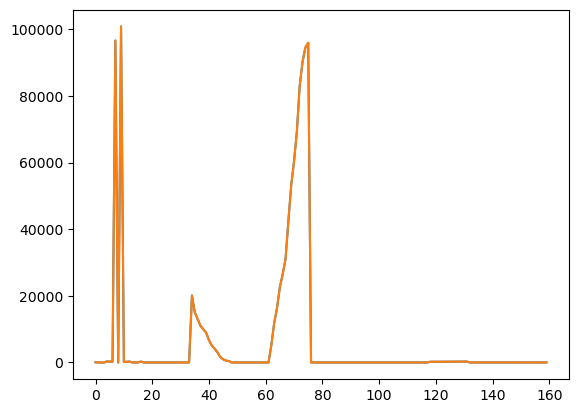

In [50]:
plt.plot(mdl.backbone.input_scalers_mu[0, 0, :, 0, 0])
plt.plot(x_mean)

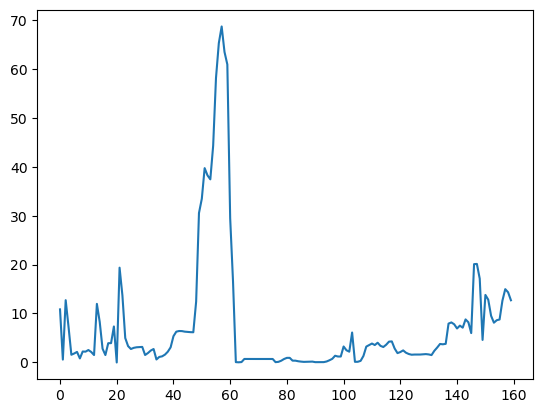

In [61]:
plt.plot(((x["x"] - mdl.backbone.input_scalers_mu[0]) / mdl.backbone.input_scalers_sigma[0]).numpy().max(axis=(-1, -2))[0])
#plt.yscale("log")

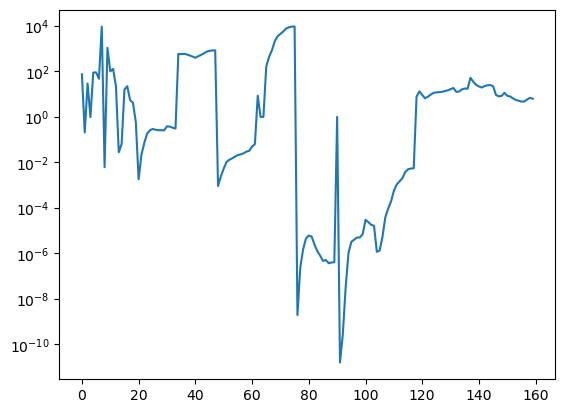

In [28]:
plt.plot(x_sigma)
plt.yscale("log")

In [63]:
x["lead_time"]

tensor(456.)